# Imports

In [1]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from itertools import groupby

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

matplotlib.style.use('ggplot')
random_seed = 123

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Here we read in our two .csv files which represent the electricity rates and generation data:

In [2]:
dfr = pd.read_csv('./data/electricity-rates.csv')
dfg = pd.read_csv('./data/electricity-generation.csv')
dfg.drop(columns=['Unnamed: 0'], inplace=True)

# Merging into one DataFrame

Separate preprocessing of rates and generation data is complete. The next step is to merge all the meaningful data into one dataframe. First, we will confirm the two dataframes have the same Year and State order:

In [3]:
dfg['Year'].equals(dfr['Year'])

True

In [4]:
dfr['State'].equals(dfr['State'])

True

The only data we need from the rates dataframe is Cents_kWh. Here we add it to the generation dataframe:

In [5]:
dfg['Cents_kWh'] = dfr['Cents_kWh_Inf_Adj']

In [6]:
dfg.head()

,Year,State,Coal,Geothermal,Hydroelectric,Natural Gas,Nuclear,Other,Other Gases,Petroleum,Solar Thermal/PV,Total,Wind,Biomass,Cents_kWh
0,1990,AK,510573,0,974521,3466261,0,0,0,497116,0,5599506,0,151035,14.17
1,1990,AL,53658115,0,10366507,1020714,12051882,0,269476,138089,0,79652133,0,2147350,8.32
2,1990,AR,19207935,0,3654653,3578573,11282053,0,0,79979,0,39099598,0,1253433,10.01
3,1990,AZ,31915610,0,7417576,2333900,20597689,0,0,151867,0,62774297,0,107888,11.58
4,1990,CA,2637677,14521254,23792567,74168308,32692807,0,2146742,5473852,366668,165784909,2758881,6239901,13.21


## Creating a "Renewables" Column

Each type of renewable energy is relatively small for most of our time period, except hydroelectric, which is the dominant generation source in some states. For clustering, we will likely want to represent renewables as a whole. For our purposes we will include the sum of hydroelectric, geothermal, biomass, solar, and wind in a "Renewables" column. 

In [7]:
dfg['Renewables'] = dfg['Hydroelectric'] + dfg['Geothermal'] + dfg['Biomass'] + dfg['Solar Thermal/PV'] + dfg['Wind']

In [8]:
dfg.tail()

,Year,State,Coal,Geothermal,Hydroelectric,Natural Gas,Nuclear,Other,Other Gases,Petroleum,Solar Thermal/PV,Total,Wind,Biomass,Cents_kWh,Renewables
1474,2018,VT,0,0,1268189,1797,0,-296,0,3132,106740,2178915,373346,426008,11.77,2174283
1475,2018,WA,5382866,0,80883377,10535078,9708441,59265,430840,23656,1695,116756729,7900094,1803179,6.22,90588345
1476,2018,WI,33322379,0,2392010,16798619,10129122,42631,0,137511,39682,65936767,1637658,1437154,8.23,5506504
1477,2018,WV,62038835,0,1847643,1420390,0,-11558,24845,158885,0,67249025,1769984,0,6.78,3617627
1478,2018,WY,39679287,0,975702,896122,0,85266,377641,40136,824,46112136,4057158,0,6.29,5033684


## Reordering and Transposing

Let's reorder our columns which represent generation sources such that non-dispatchable are first, dispatchable are second, and intermittent are last. That way when we start plotting, the order of the stack will be meaningful, with non-dispatchable at the bottom of the plot, dispatchable in the middle, and intermittent at the top.

In [9]:
columns = ['Year', 'State', 'Coal', 'Nuclear',  'Petroleum',
           'Natural Gas',  'Other Gases', 'Other', 'Hydroelectric', 'Geothermal', 
           'Biomass', 'Solar Thermal/PV', 'Wind', 'Renewables', 'Total', 'Cents_kWh']
dfg=dfg.reindex(columns=columns)

In [10]:
dfg.head()

,Year,State,Coal,Nuclear,Petroleum,Natural Gas,Other Gases,Other,Hydroelectric,Geothermal,Biomass,Solar Thermal/PV,Wind,Renewables,Total,Cents_kWh
0,1990,AK,510573,0,497116,3466261,0,0,974521,0,151035,0,0,1125556,5599506,14.17
1,1990,AL,53658115,12051882,138089,1020714,269476,0,10366507,0,2147350,0,0,12513857,79652133,8.32
2,1990,AR,19207935,11282053,79979,3578573,0,0,3654653,0,1253433,0,0,4908086,39099598,10.01
3,1990,AZ,31915610,20597689,151867,2333900,0,0,7417576,0,107888,0,0,7525464,62774297,11.58
4,1990,CA,2637677,32692807,5473852,74168308,2146742,0,23792567,14521254,6239901,366668,2758881,47679271,165784909,13.21


## Normalizing Generation Totals

Our generation data is given by EIA in megawatt hours (MWh). For our purposes we prefer the data to be scaled such that each generation source is expressed as a fraction of the state's total. The first step is to transpose the dataframe, as it is quite convenient to operate on columns:

In [11]:
dfg_transposed = dfg.T

# Here is an example of what one of the transposed rows looks like:
dfg_transposed[[0]]

,0
Year,1990
State,AK
Coal,510573
Nuclear,0
Petroleum,497116
Natural Gas,3466261
Other Gases,0
Other,0
Hydroelectric,974521
Geothermal,0


This loop will normalize our generation data:

In [12]:
for i in range(len(dfg_transposed.columns)):
    dfg_transposed[i][2:15] = dfg_transposed[i][2:15] / dfg_transposed[i][14]

In [13]:
# Here is an example of a normalized column. Note that "Cents_kWh" is not altered:
dfg_transposed[[0]]

,0
Year,1990
State,AK
Coal,0.0911818
Nuclear,0
Petroleum,0.0887785
Natural Gas,0.61903
Other Gases,0
Other,0
Hydroelectric,0.174037
Geothermal,0


Now we'll undo the transposition

In [14]:
dfg = dfg_transposed.T
dfg.head()

,Year,State,Coal,Nuclear,Petroleum,Natural Gas,Other Gases,Other,Hydroelectric,Geothermal,Biomass,Solar Thermal/PV,Wind,Renewables,Total,Cents_kWh
0,1990,AK,0.0911818,0,0.0887785,0.61903,0,0,0.174037,0,0.0269729,0,0,0.20101,1,14.17
1,1990,AL,0.673656,0.151306,0.00173365,0.0128146,0.00338316,0,0.130147,0,0.0269591,0,0,0.157106,1,8.32
2,1990,AR,0.491257,0.288547,0.00204552,0.0915245,0,0,0.0934703,0,0.0320574,0,0,0.125528,1,10.01
3,1990,AZ,0.508418,0.328123,0.00241925,0.0371792,0,0,0.118163,0,0.00171867,0,0,0.119881,1,11.58
4,1990,CA,0.0159102,0.1972,0.0330178,0.447377,0.012949,0,0.143515,0.0875909,0.0376385,0.00221171,0.0166413,0.287597,1,13.21


We no longer need the 'Total" column. Its only purpose was to allow us to normalize, so we can safely drop it:

In [15]:
dfg.drop(columns='Total', inplace=True)

In the transposition, we lost our preferred datatypes, so we will reset them below:

In [16]:
dfg.dtypes.head()

Year         object
State        object
Coal         object
Nuclear      object
Petroleum    object
dtype: object

In [17]:
cols = dfg.columns.drop('State')
dfg[cols] = dfg[cols].apply(pd.to_numeric, errors='coerce')

## Grouping Renewables

Here we define collections of columns for use in visualization and clutsering. We will have the option of working with renewables as a combined total, or individually. When renewables are represented independently, they will be color coded in the most intuitive way possible: 

Hydro - blue<br>
Geothermal - brown<br>
Biomass - green<br>
Solar - gold<br>
Wind - sky blue<br>

If renewables are represented a combined group, they will be green of course!

In [18]:
# This column list is for cases where we want to represent
# each of the 5 renewable generation sources independently
gen_cols = ['Coal', 'Nuclear', 'Petroleum', 'Natural Gas',
            'Other Gases', 'Other', 'Hydroelectric', 'Geothermal',
            'Biomass','Solar Thermal/PV', 'Wind']

# Renewables will be color-coded in the most intuive way possible
# Hydro = blue, Geothermal = brown, Biomass = green, Solar = gold, Wind = skyblue
gen_colors=['black', 'rebeccapurple', 'whitesmoke', 
            'silver', 'slategray', 'plum',
            'royalblue', 'saddlebrown', 'green', 'gold', 'skyblue']

# This column list excludes the 5 renewable sources and includes instead
# the total of those 5, "Renewables"
ren_cols = ['Coal', 'Nuclear', 'Petroleum', 'Natural Gas',
            'Other Gases', 'Other', 'Renewables']

# If renewables are plotted as a group, they will be green
ren_colors = ['black', 'rebeccapurple', 'whitesmoke', 
              'silver', 'slategray', 'plum', 'green']

# Visualization Functions

There are two ways we will want to be able to visualize generation profile: 

1) Each type of renewable generation represented as its own category<br>
2) All renewables are represented as one category

The "all renewables" category will be important when we begin using clustering algorithms. In most states individually they are small compared to fossil fuel generation, and would not factor into clustering significantly unless combined into one category. 

## Stackplots

Stackplots allow us to visualize each state for the entire available period of 1990-2018. This plot expresses a lot of information. By color it is easy to discern generation source over time, and positioning in the stack indicates dispatchability, intermittency, and emissions:

- Wind and solar, zero-emissions and intermittent, are on top, in sky blue and gold
- Biomass and geothermal, zero-emissions and renewable but non-dispatchable, are in green and brown.
- Hydroelectric, both renewable and dispatchable, is in blue.
- Dispatchable fossil fuels, which pair well with intermittent renewables, and in the middle layers, in white to gray shades.
- Nuclear and coal, non-dispatchable generation sources, are at the bottom, in purple and black. 

If a visualization with one combined renewables category is desirable, wind, solar, biomass, geothernal, and hydroelectric are together green.

### Stackplot

In [19]:
def stackplot(dataframe, state, columns, figsize1, figsize2):
    
    x = list(dataframe['Year'].unique())  # getting our list of years for x-axis
    fig, ax = plt.subplots(figsize = (figsize1, figsize2))
    
    # we can either display each renewable gen source separately:
    if columns == "gen_cols":
        y = dataframe[dataframe['State'] == state].iloc[:, 2:13].T.values.tolist()
        ax.stackplot(x, y, labels=gen_cols, colors=gen_colors)
    # or we can use the combined renewables column:
    else:
        y = dataframe[dataframe['State'] == state].iloc[:, np.r_[2:8,13]].T.values.tolist()        
        ax.stackplot(x, y, labels=ren_cols, colors=ren_colors)
    
    # placing the legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper left', bbox_to_anchor=(1, 1), prop={'size':16})
    
    ax.set_title("{} Electricity Generation from 1990-2018".format(state), fontsize=28)
    ax.set_xlabel("Year", size=24)
    ax.set_ylabel("Generation Source Fraction", size=24)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.box(on=None)

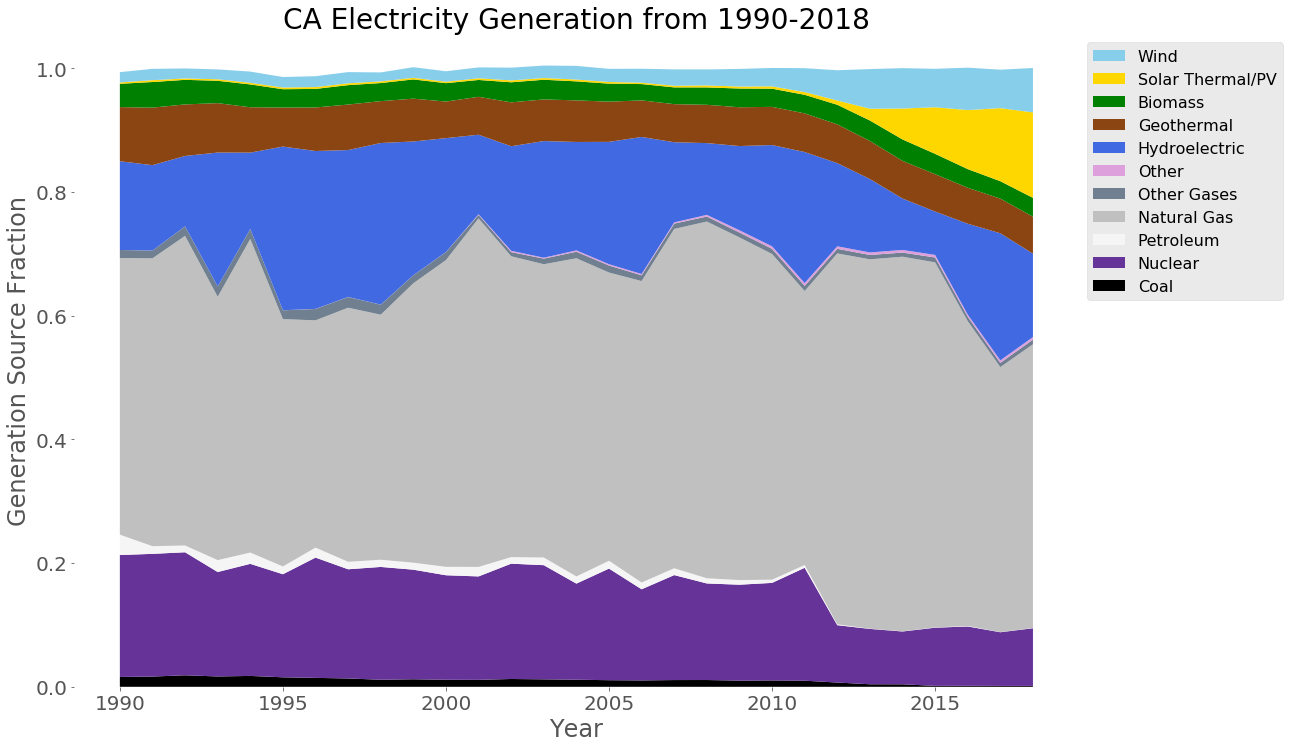

In [20]:
stackplot(dfg, "CA", "gen_cols", 18, 12)

**Interpretation**: California is an interesting case, as the state with the most progressive environmental policies for most of the time period analyzed. It's clear California started deploying renewables early, but at relatively small scale. Starting around 2011, solar began growing rapidly, while nuclear declined due to the closure of the San Onofre plant in 2013. Droughts, when gas took the place of hydroelectric, are also discernable.

### Stackplot Subplots

In [21]:
def stackplots(dataframe, states, columns):
    
    # laying out our two columns of plots
    nrows = int(np.ceil(len(states)/2))
    height = nrows * 6
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize = (18,height))
    ax = ax.ravel()
    
    for i, state in enumerate(states):
        
        # getting our list of years for x-axis
        x = list(dataframe['Year'].unique())
        
        # we can either display each renewable gen source separately:
        if columns == "gen_cols":
            y = dataframe[dataframe['State'] == state].iloc[:, 2:13].T.values.tolist()
            ax[i].stackplot(x, y, labels=gen_cols, colors=gen_colors)
        
        # or we can use the combined renewables column:
        else:
            y = dataframe[dataframe['State'] == state].iloc[:, np.r_[2:8,13]].T.values.tolist()        
            ax[i].stackplot(x, y, labels=ren_cols, colors=ren_colors)
            
        ax[i].set_title("{} Electricity Generation from 1990-2018".format(states[i]), size=20)
        ax[i].set_xlabel("Year", size=18)
        ax[i].set_ylabel("Generation Source Fraction", size=18)
        
        # placing the legend
        handles, labels = ax[i].get_legend_handles_labels()
        ax[i].legend(reversed(handles), reversed(labels), loc='upper left', prop={'size':8})
        
        #Turn off odd number of subplots
        if len(states) % 2 == 1:       
            ax[-1].axis('off')
    
    # beautification
    plt.tight_layout(h_pad = 3, w_pad = 2)
    plt.grid(True)
    plt.box(on=None)

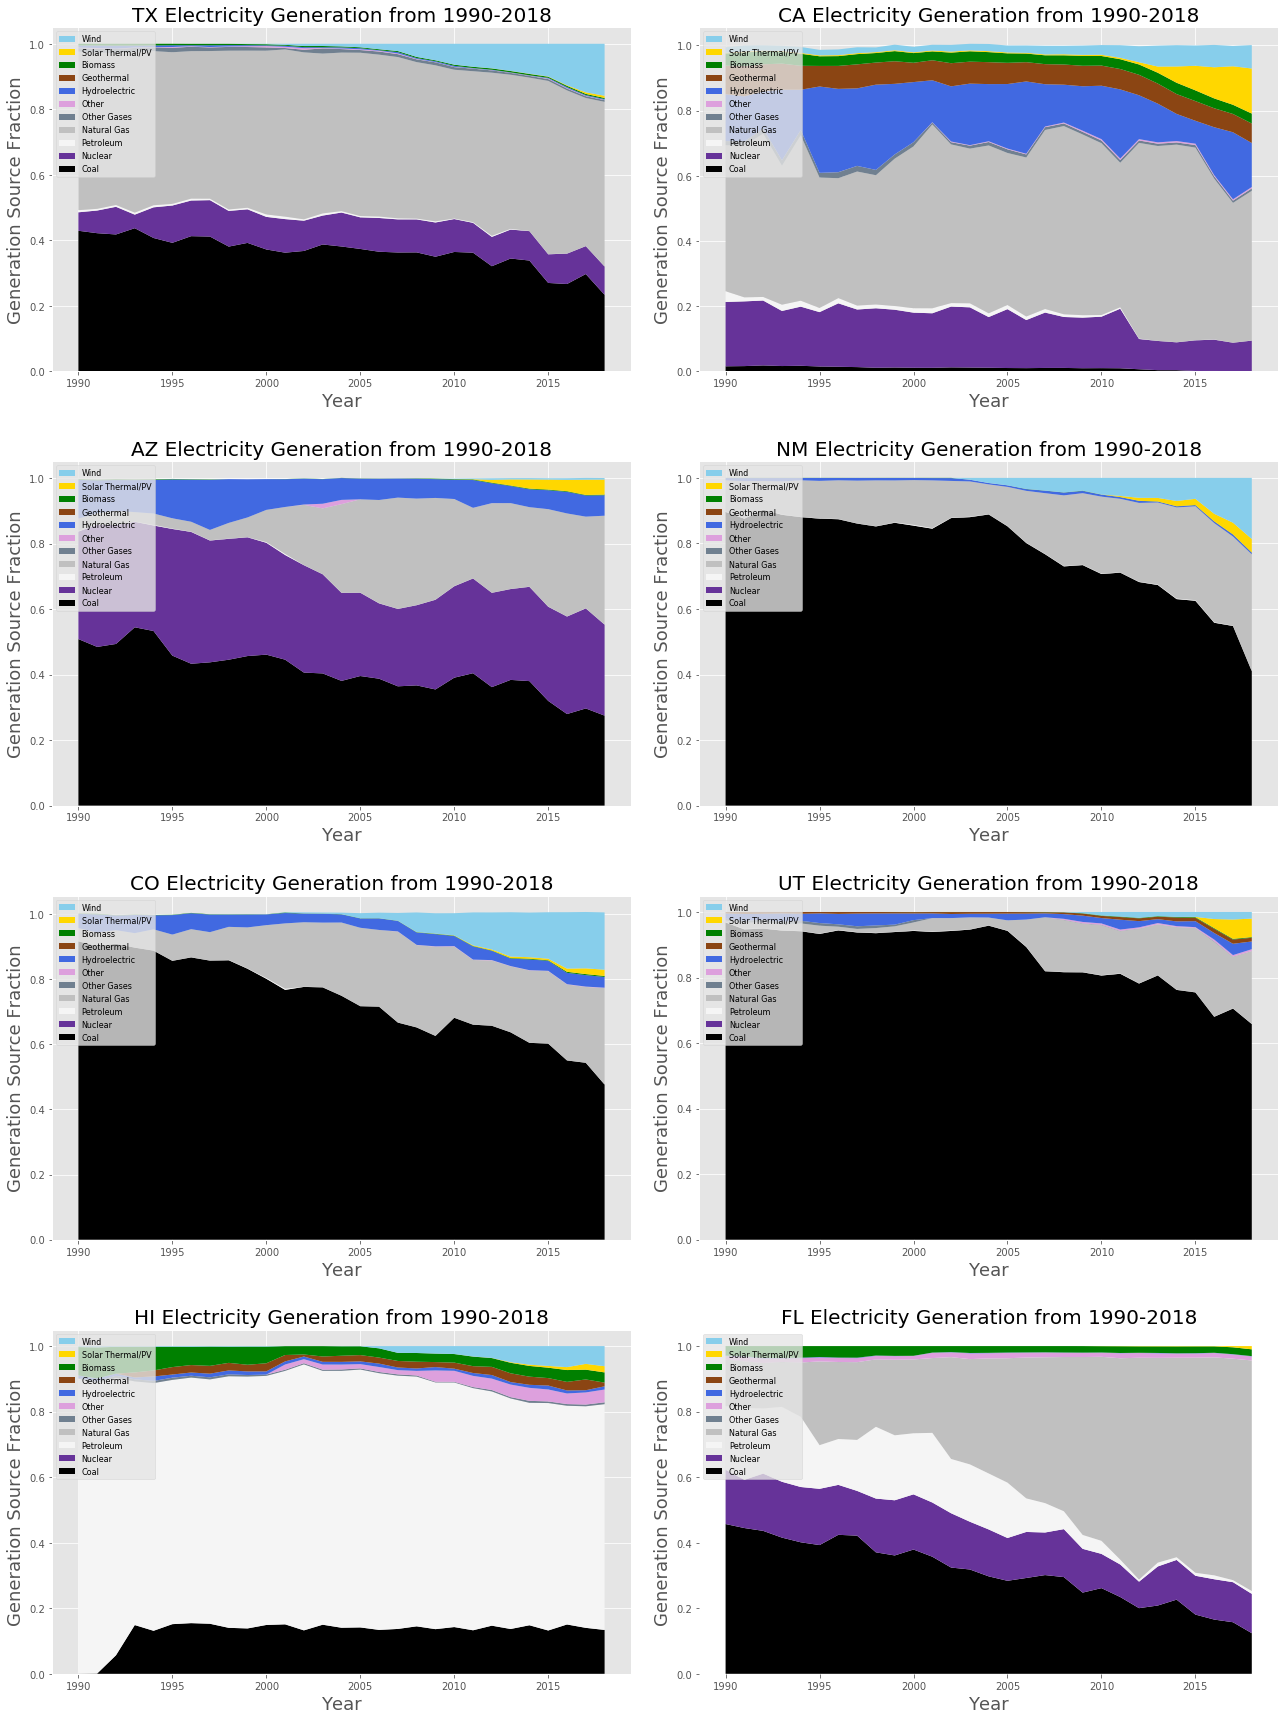

In [22]:
stackplots(dfg, ['TX', 'CA', 'AZ', 'NM', 'CO', 'UT', 'HI', 'FL'], "gen_cols")

**Interpretation:** These eightstates represent those with the greatest solar resource according to NREL. With the proper regulatory framework, all would be poised for a rapid increase in solar generation, such as California is already experiencing. 

## Barplots

Bar plots allow us to visualize a state at a given point in time. This plot is much easier to interpret at a glance than the stackplot, and allows us to offer a high-level snapshot of a group of states. We retain the color scheme from the stackplot for consistency.

As with stackplots, a function is available to visualize with each renewable its own color-coded bar, or with one combined renewables category in green.

### Bar Plot

In [23]:
def barplot(dataframe, state, columns, year, figsize1, figsize2):

    fig, ax = plt.subplots(figsize = (figsize1, figsize2))
    
    # we can either display each renewable gen source separately:
    if columns == "gen_cols":
        height = dataframe.loc[(dataframe['State'] == state) & (dataframe['Year'] == year)].iloc[:, 2:13].T.squeeze()
        ax.bar(x=gen_cols, height=height, color=gen_colors, edgecolor='black')
    
    # or we can use the combined renewables column:
    else:
        height = dataframe.loc[(dataframe['State'] == state) & (dataframe['Year'] == year)].iloc[:, np.r_[2:8,13]].T.squeeze()
        ax.bar(x=ren_cols, height=height, color=ren_colors, edgecolor='black')    
    
    ax.set_title("{} Electricity Generation in {}".format(state, year), fontsize=28)
    ax.set_xlabel("Source", size=24)
    ax.set_ylabel("Generation Source Fraction", size=24)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20, rotation = 55, ha="right")

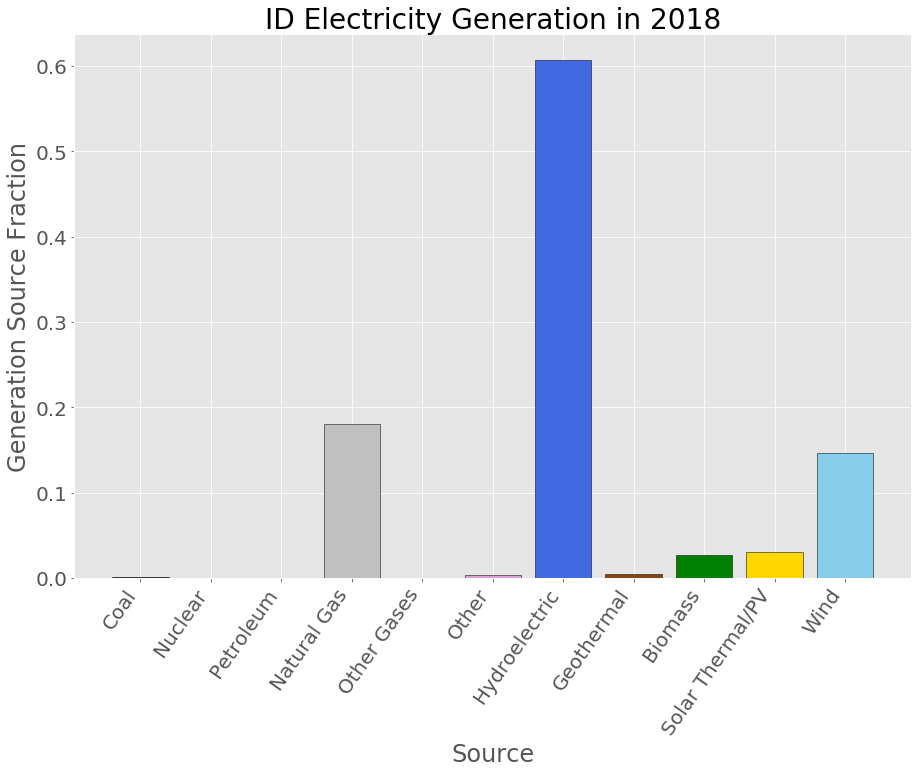

In [24]:
barplot(dfg, "ID", "gen_cols", 2018, 15, 10)

**Interpretation:** Idaho is blessed with abundant hydroelectric resources, making it a top state for overall renewable generation profile. Natural gas and wind are both significant sources. Idaho likely has the opportunity to integrate more renewable generation at the expense of natural gas due to the dispatchability of hydroelectric to balance the intermittency of wind and solar.

### Bar Plots Subplots

In [25]:
def barplots(dataframe, states, columns, year):
    nrows = int(np.ceil(len(states)/2))
    height = nrows * 7
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize = (18,height))
    ax = ax.ravel()
    for i, state in enumerate(states):
        
        # we can either display each renewable gen source separately:
        if columns == "gen_cols":
            barheight = dataframe.loc[(dataframe['State'] == state) & (dataframe['Year'] == year)].iloc[:, 2:13].T.squeeze()
            ax[i].bar(x=gen_cols, height=barheight, color=gen_colors, edgecolor='black')
            ax[i].set_xticklabels(labels=gen_cols, rotation=45, ha='right')
        
        # or we can use the combined renewables column:
        else:
            barheight = dataframe.loc[(dataframe['State'] == state) & (dataframe['Year'] == year)].iloc[:, np.r_[2:8,13]].T.squeeze()       
            ax[i].bar(x=ren_cols, height=barheight, color=ren_colors, edgecolor='black') 
            ax[i].set_xticklabels(labels=ren_cols, rotation=55, ha='right')
    
        ax[i].set_title("{} Electricity Generation in {}".format(state, year), fontsize=28)
        ax[i].set_xlabel("Source", size=24)
        ax[i].set_ylabel("Gen. Source Fraction", size=24)
        ax[i].tick_params(labelsize=14)
        plt.tight_layout(h_pad = 3, w_pad = 2)
        
        #Turn off odd number of subplots
        if len(states) % 2 == 1:       
            ax[-1].axis('off')

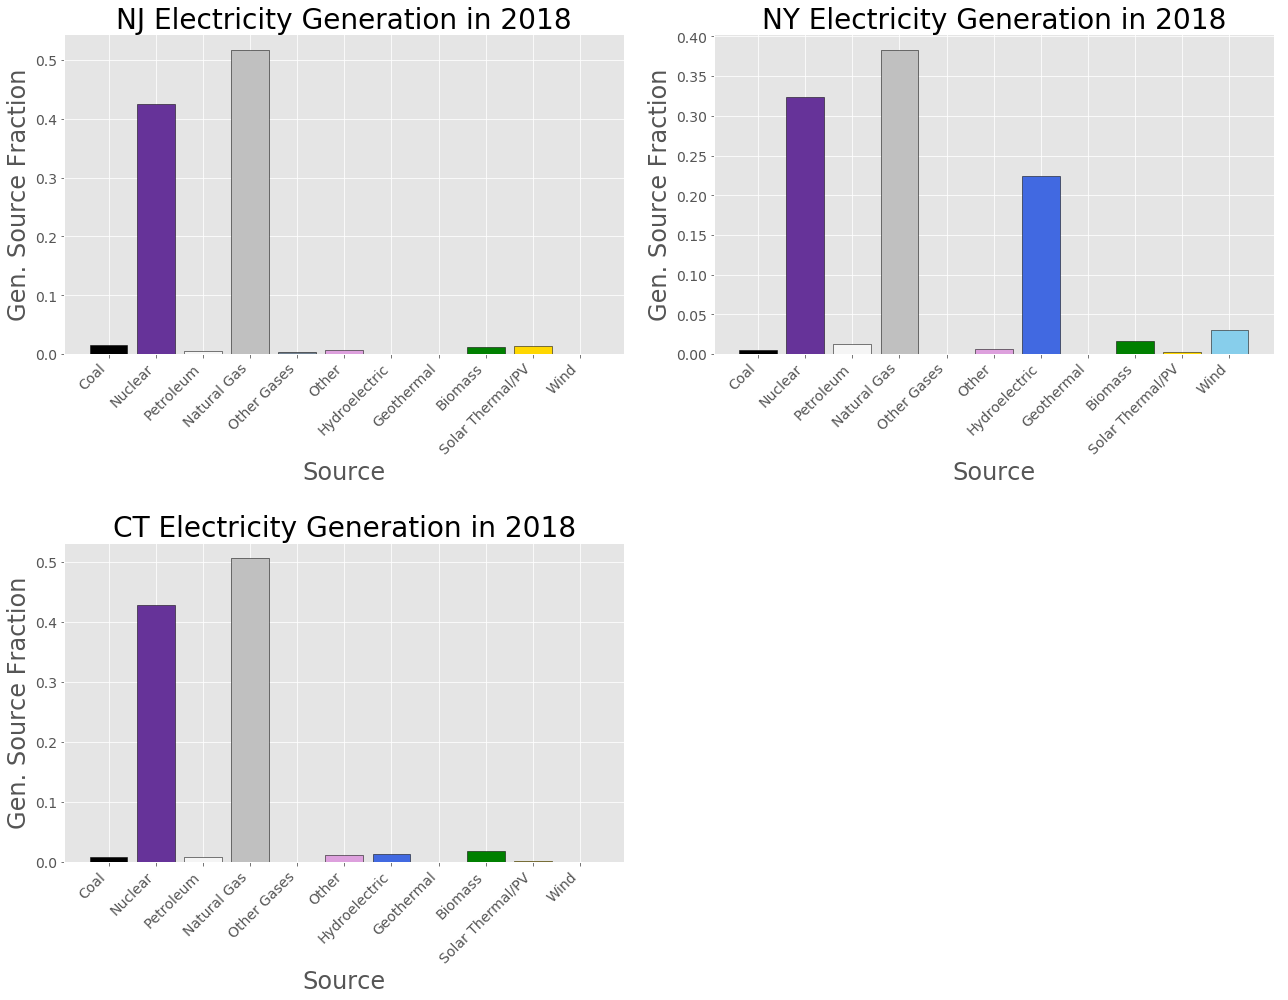

In [26]:
barplots(dfg, ['NJ', 'NY', 'CT'], "gen_cols", 2018)

**Interpretation:** Here we can see the tri-state area's current generation profile. The states are very similar with natural gas and nuclear generating the great majority of electricity. NY State has geographic advantages of open land for wind generation and damnable rivers for hydroelectric.

# Clustering States by Generation Profile

## K-Means Clustering

K-Means clustering requires all data points to be part of a cluster. This is sometimes considered a disadvantage of the algorithm, but with only 51 states, this may not be significant. We will experiment with cluster counts from 3 to 7 and choose the one with the highest silhouette score, for each year of data we have. _We will consider renewables as a combined category, so their scale approaches that of fossil fuels._

### By Year and Best Silhouette score

In [27]:
k_list = []        # we will accumulate each year's cluster count in this list
cl_lab_list = []   # we will accumulate each state's cluster labed, for each year, in this list

for year in range(1990, 2019):
    scores = []    # this list is for accumulating year, cluster count, and silhouette score
    
    # We will feed KMeans one year at a time of states with their generation profiles, with State as index
    X = dfg[(dfg['Year'] == year)][ren_cols].set_index(dfg['State'].iloc[0:51].values)
    
    for k in range(3, 8):  # we will evaluate 3-7 clusters, and choose the one with highest silhouette score
        cl = KMeans(n_clusters=k, random_state = 123)
        cl.fit(X)
        sil = silhouette_score(X, cl.labels_)
        scores.append([year, k, sil]) # add the year, cluster count, and silhouette score to the list
        score_df = pd.DataFrame(scores)  # createa a dataframe of scores
        score_df.columns = ['year', 'k', 'silhouette']  # name the columns
        
    # for each year, choose the cluster count corresponding to the highest silhouette score
    best_k = score_df.nlargest(n=1, columns='silhouette')['k'].values[0] 
 
    k_list.extend([best_k]*51)  # record the cluster count w/ highest silhouette score in each state's row
                                # multiply by 51 to record the same cluster count in all rows for the year
    
    # instantiate and fit the model with the optimal cluster count, and record each state's cluster membership
    cl = KMeans(n_clusters=best_k, random_state = 123)  
    cl.fit(X)
    cl_lab_list.extend(cl.labels_)
    
    ### Uncomment the line below to see each year's highest-silhouette score cluster count
    # print(f"{year}'s best cluster count is {best_k}.")
    
dfg['km_count'] = k_list  # add a column to the main dataframe with cluster count
dfg['k_cluster'] = cl_lab_list # add a column to the main dataframe with cluster membership

### Cluster Count by Year

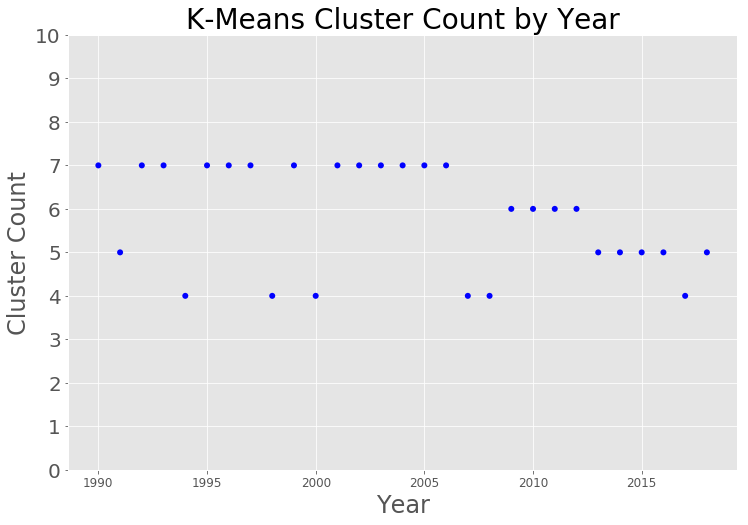

In [28]:
x = dfg['Year'].unique()
y = dfg.groupby('Year')['km_count'].mean().values
fig, ax = plt.subplots(figsize = (12,8));
    
ax.scatter(x, y, color='blue', edgecolors='none');
ax.set_title("K-Means Cluster Count by Year", fontsize=28);
ax.set_xlabel("Year", size=24);
ax.set_ylabel("Cluster Count", size=24);
plt.yticks(fontsize=20);
major_ticks = np.arange(0, 11, 1)
ax.set_yticks(major_ticks)
plt.xticks(fontsize=12);

**Interpretation:** A trend of fewer clusters over time is clear. By comparing the 1990 clusters with 2018, and tracing which two clusters consistently no longer appear, we can get a sense of electricity generation trends over time. The changes in the K-Means clustering results are the story of the decline of coal, the rise of natural gas, and the diversification of generation profiles across the nation.

In 1990, there is a cluster of 5 states whose generation profile is over 50% nuclear: Connecticut, Illinois, New Jersey, South Carolina, and Vermont. By 2018, of these 5 states, only South Carolina remains with >50% nuclear. In 2018, the nuclear cluster has vanished, and a more diversified South Carolina clusters with a group of states whose overall profile is mixed. South Carolina's profile now includes around 22% natural gas, as opposed to around 1% in 1990. 

Also, in 1990 there are two separate clusters that are coal-dominant. One is a cluster of 14 states whose generation profile is overwhelmingly coal, and another of 16 coal-heavy states but with a mix of nuclear or hydro. Of these 30 states in 1990, 26 get more than 50% of their generation from coal. By 2018, only one coal-dominant cluster of 16 states is identified, and of those only 8 get more than 50% of their energy from coal. 

## DBSCAN

DBSCAN offers the benefit of being less sensitive to initial conditions, and it does not require us to choose the cluster size. However it does not perform well with clusters of varying density, and it requires us to choose two parameters, epsilon and minimum samples. We will experiment with epsilon from .01 to 1.0, and we will require a minimum of 3 samples to constitute a cluster.

In [29]:
# this function will allow us to get a count of DBSCAN outliers
def count_of_first(myarray):
    mylist = list(myarray)
    mylist.sort()
    return [len(list(group)) for key, group in groupby(mylist)][0]

In [30]:
db_list = []      # to hold each year's optimal DBSCAN labels count, which is clusters + 1 for outliers 
db_lab_list = []  # to hold each state's DBSCAN label
outlier_list = [] # to hold each year's DBSCAN outlier count, so we can evaluate DBSCAN's performance

for year in range(1990, 2019):
    scores = []   # this will hold 100 possible epsilon values and the resulting DBVSCAN labels
                  # and silhouette score which we'll use to choose the optimal epsilon for each year
    
    # we will use the combined renewables column rather than 5 separate renewable generation sources
    # otherwise, renewables are unlikley to have a significant impact
    X = dfg[(dfg['Year'] == year)][ren_cols].set_index(dfg['State'].iloc[0:51].values)
    
    for i in range(1,101):
        eps=i/100  # testing with epsilon .01, .02, .03 .... 1.0
        dbscan = DBSCAN(eps=eps, min_samples=3)
        dbscan.fit(X)
        db_labs = set(dbscan.labels_) # isolate our DBSCAN labels
        db_labs_count = len(db_labs)  # find out how many DBSCAN labels this epsilon resulted in
        if len(set(dbscan.labels_)) < 4:  
            continue                 # 4 labels = 3 clusters plus outliers, unlikely to provide insights
                                     # so we will set a limit of at least 3 clusters plus outliers
                
        sil = silhouette_score(X, dbscan.labels_) # we will use silhouette score to evaluate 
                                                  # each of our epsilon scores, highest will win
        
        scores.append([year, eps, db_labs,  # accumulate year epsilon, DBSCAN label for each state,
                       db_labs_count, sil]) # count of DBSCAN labels, and silhouette score
        
        score_df = pd.DataFrame(scores)      # creating a dataframe to hold our scoring data
        score_df.columns = ['year', 'eps', 'DBSCAN labels',  # give the dataframe column names
                            'DBSCAN label count','silhouette']
    
    # score_df now has all the year's possible epsilon scores
    # here we'll extract the epsilon and count of DBSCAN labels with the highest epsilon score
    best_eps = score_df.nlargest(n=1, columns='silhouette')['eps'].values[0]
    best_labels_count = score_df.nlargest(n=1, columns='silhouette')['DBSCAN label count'].values[0]
    
    db_list.extend([best_labels_count] * 51) # the best labels count is identical for every state, each year
    dbscan = DBSCAN(eps=best_eps, min_samples=3)    
    dbscan.fit(X)
    outlier_count = count_of_first(dbscan.labels_) # get our outlier count via the function we created above
    
    ### The code below will add a long printout of each years' DBSCAN parameters ###
    #print(f"{year}'s best epsilon: {best_eps}. DBSCAN label count is: {best_labels_count}. Cluster count is {best_labels_count - 1}. Outlier count: {outlier_count}.")
    
    db_lab_list.extend(dbscan.labels_) # accumulate each state's DBSCAN label for the year
    outlier_list.extend([outlier_count] * 51) # outlier count is identical for every state, each year

dfg['DB_label_count'] = db_list # append label count to our df as a column
dfg['DB_cluster'] = db_lab_list # append each state's DBSCAN cluster label to our df as a column
dfg['DB_outlier_count'] = outlier_list # append the outlier count to our df as a column

In the dataframe, the added columns for K-Means and DBSCAN output can be seen at the far right:

In [31]:
dfg.head()

,Year,State,Coal,Nuclear,Petroleum,Natural Gas,Other Gases,Other,Hydroelectric,Geothermal,Biomass,Solar Thermal/PV,Wind,Renewables,Cents_kWh,km_count,k_cluster,DB_label_count,DB_cluster,DB_outlier_count
0,1990,AK,0.091182,0.000000,0.088779,0.619030,0.000000,0.0,0.174037,0.000000,0.026973,0.000000,0.000000,0.201010,14.17,7,4,4,0,3
1,1990,AL,0.673656,0.151306,0.001734,0.012815,0.003383,0.0,0.130147,0.000000,0.026959,0.000000,0.000000,0.157106,8.32,7,1,4,1,3
2,1990,AR,0.491257,0.288547,0.002046,0.091525,0.000000,0.0,0.093470,0.000000,0.032057,0.000000,0.000000,0.125528,10.01,7,1,4,1,3
3,1990,AZ,0.508418,0.328123,0.002419,0.037179,0.000000,0.0,0.118163,0.000000,0.001719,0.000000,0.000000,0.119881,11.58,7,1,4,1,3
4,1990,CA,0.015910,0.197200,0.033018,0.447377,0.012949,0.0,0.143515,0.087591,0.037639,0.002212,0.016641,0.287597,13.21,7,4,4,0,3


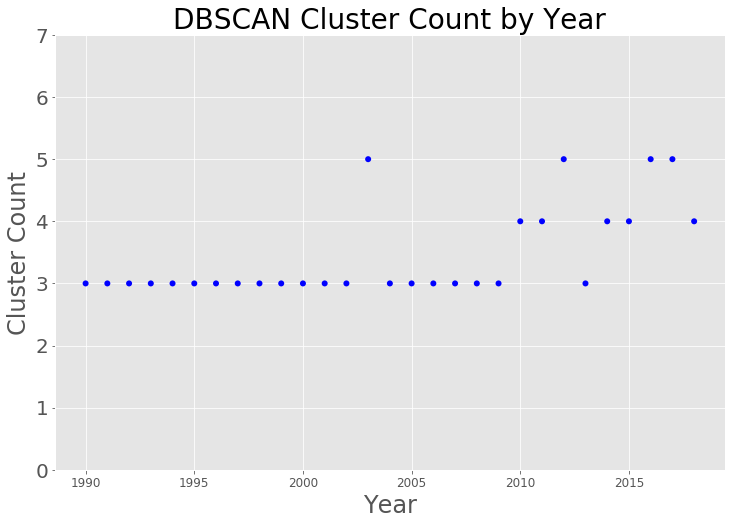

In [32]:
x = dfg['Year'].unique()
y = dfg.groupby('Year')['DB_label_count'].mean().values - 1
fig, ax = plt.subplots(figsize = (12,8));
    
ax.scatter(x, y, color='blue', edgecolors='none');
ax.set_title("DBSCAN Cluster Count by Year", fontsize=28);
ax.set_xlabel("Year", size=24);
ax.set_ylabel("Cluster Count", size=24);
plt.yticks(fontsize=20);
major_ticks = np.arange(0, 8, 1)
ax.set_yticks(major_ticks)
plt.xticks(fontsize=12);

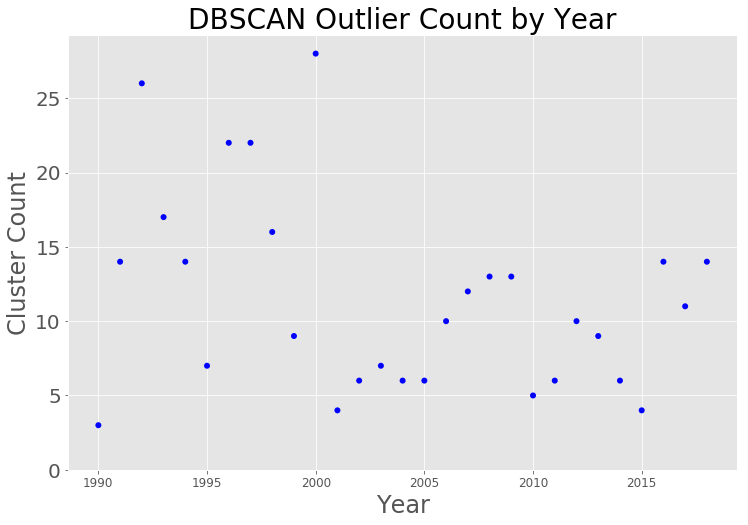

In [33]:
x = dfg['Year'].unique()
y = dfg.groupby('Year')['DB_outlier_count'].mean().values
fig, ax = plt.subplots(figsize = (12,8));
    
ax.scatter(x, y, color='blue', edgecolors='none');
ax.set_title("DBSCAN Outlier Count by Year", fontsize=28);
ax.set_xlabel("Year", size=24);
ax.set_ylabel("Cluster Count", size=24);
plt.yticks(fontsize=20);
major_ticks = np.arange(0, 30, 5)
ax.set_yticks(major_ticks)
plt.xticks(fontsize=12);

**Interpretation:** DBSCAN consistently identifies 3 clusters, with only one interruption, from 1990 until 2010. These three consistently appearing clusters constitute: states with signficant natural gas generation; states whose generation is mostly renewable (hydro, in this case); and states with a significant amount of either coal, nuclear, or both, with one exception (Maine) whose profile is mixed nuclear and hydro. 

# Visualizing Clusters

With our two clustering algorithms' data recorded we can now visualize states by year, algorithm, and cluster membership, and we can choose to display renewables as one overall category, or to view the 5 constituent renewable categories separately. The function below will simplify the visualization process.

## KMeans Cluster Visualization

In [34]:
def km_viz(year, k_cluster, cols, plot_type="stack"):
    
    # select all states by year and KMeans cluster
    km_states = list(dfg[(dfg['Year'] == year) & (dfg['k_cluster'] == k_cluster)]['State'].values)
    
    if plot_type == "stack":
        stackplots(dfg, km_states, cols)
    elif plot_type == "bar":
        barplots(dfg, km_states, cols, year)

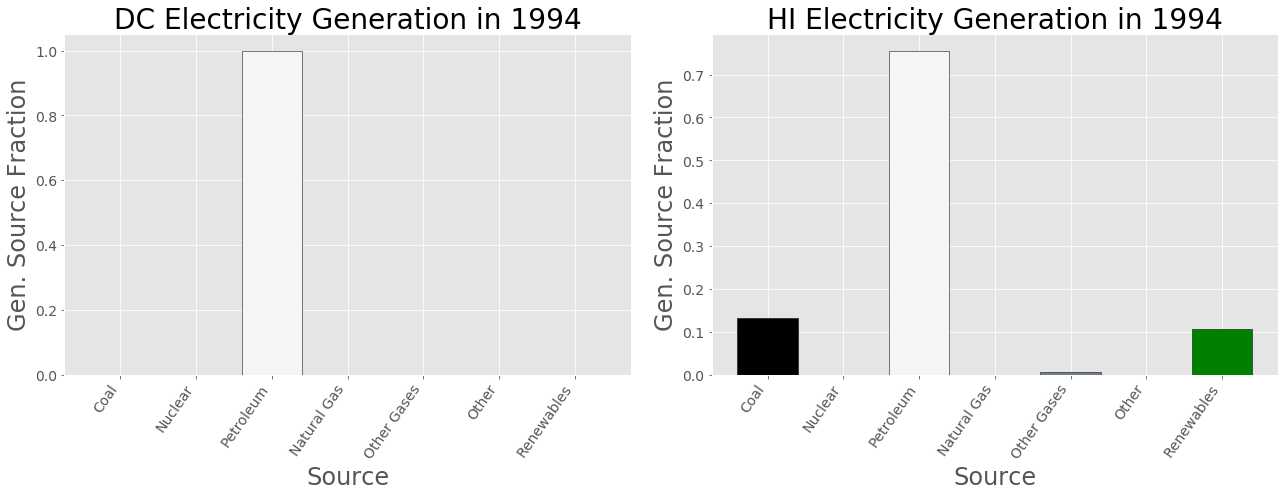

In [49]:
km_viz(1994, 3, "ren_cols", "bar")

**Interpretation:** K-Means clustering identifies the petroleum-dependent states of DC and HI as a distinct cluster. In later years of our analysis DC replaces petroleum with natural gas and biomass. K-Means continues to identify Hawaii as its own unique cluster of one, still dependent on petroleum, transported at great cost by boat. This explains Hawaii's highest-in-the-nation electricity rates, as well as their progressive Renewable Portfolio Standard (RPS) of 100% by 2045, with interim RPS requirements of 30% by 2020, 40% by 2030, and 70% by 2040,

## DBSCAN Cluster Visualization

In [36]:
def db_viz(year, db_cluster, cols, plot_type="stack"):
    
    # select all states by year and DBSCAN cluster assignment, including outliers as -1
    db_states = list(dfg[(dfg['Year'] == year) & (dfg['DB_cluster'] == db_cluster)]['State'].values)
    
    if plot_type == "stack":
        stackplots(dfg, db_states, cols)
    elif plot_type == "bar":
        barplots(dfg, db_states, cols, year)

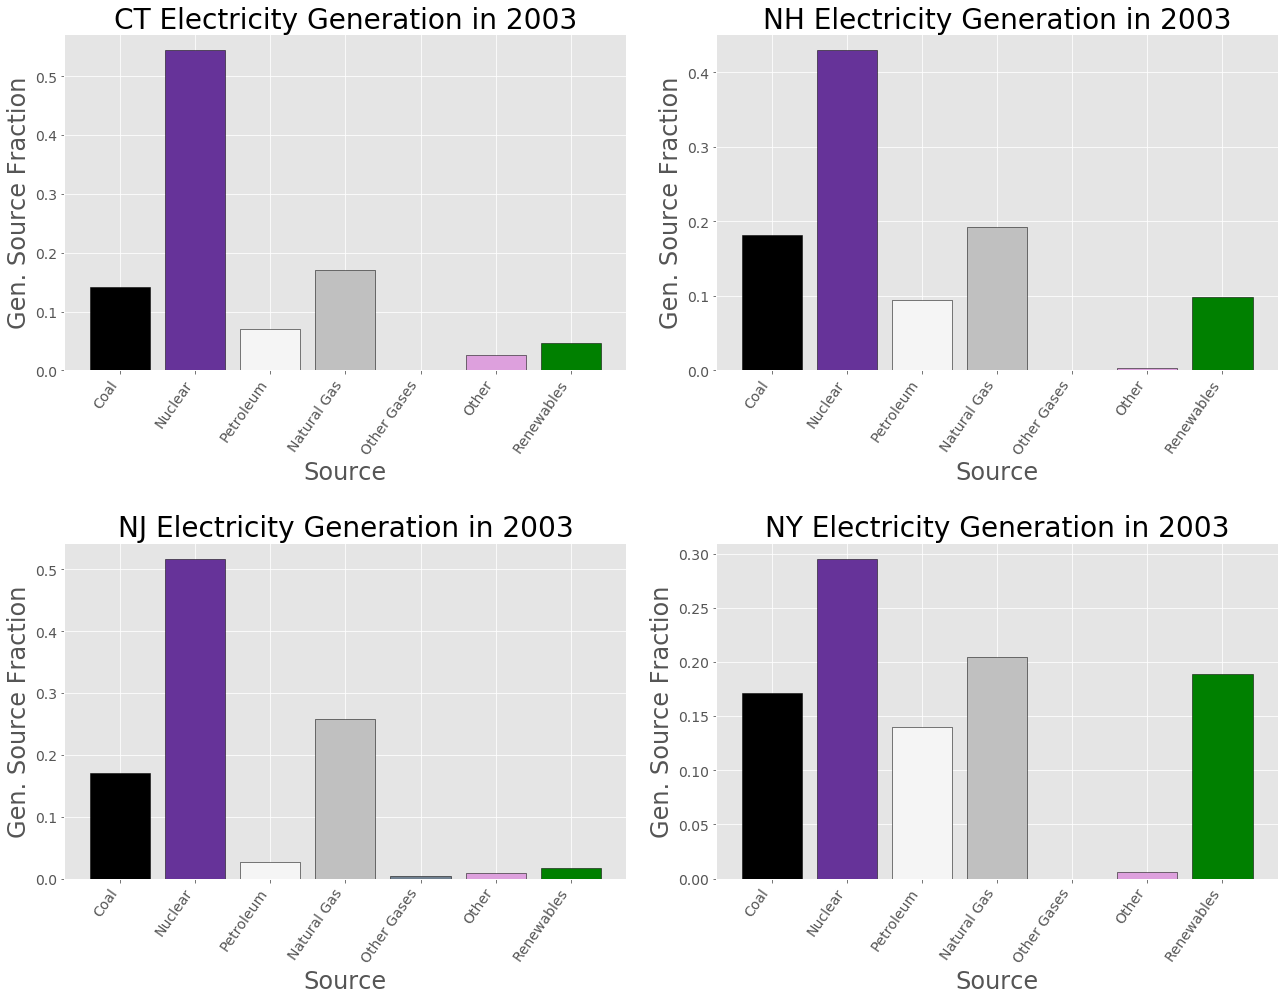

In [37]:
db_viz(2003, 1, "ren_cols", "bar")

**Interpretation:** DBSCAN identifies this cluster of nuclear-heavy generation profile states, with additional coal, gas, petroleum, and renewable, in 2003. In most other years, DBSCAN identified these states and their generation profile type as outliers and did not assign them to a cluster at all. 

Overall DBSCAN is less consistent than K-Means clustering for our particular dataset. It makes more sense to force all states to be part of a cluster, as K-Means does, than to allow some to be identified as outliers. 

# Electricity Rates and Generation Profile

There are challenges when approaching electricity rates with machine learning, in the context of our dataset. We have only 29 years of data to work with, for too short a time to identify cyclic trends. However plotting standardized electricity rates over the stackplot will allow a visual analysis.

## Visualization function

In [38]:
def stack_rate(dataframe, state, columns, figsize1, figsize2):
    
    x = list(dataframe['Year'].unique())
    fig, ax = plt.subplots(figsize = (figsize1, figsize2))
    
    if columns == "gen_cols":
        y = dataframe[dataframe['State'] == state].iloc[:, 2:13].T.values.tolist()
        ax.stackplot(x, y, labels=gen_cols, colors=gen_colors)
    else:
        y = dataframe[dataframe['State'] == state].iloc[:, np.r_[2:8,13]].T.values.tolist()        
        ax.stackplot(x, y, labels=ren_cols, colors=ren_colors)
    
    y_list = []
    for year in x:
        y_list.append((float(dfg.loc[(dfg['State']== state) & (dfg['Year'] == year)]['Cents_kWh']) / dfg[dfg['State']==state]['Cents_kWh'].mean())-0.5)
    ax.plot(x, y_list, color='red', linewidth=5)
    ax.axhline(0.5, 0.05, 0.95)
    
    handles, labels = ax.get_legend_handles_labels()
    red_patch = mpatches.Patch(color='red')
    handles.insert(0, red_patch)
    labels.insert(0, "Rates")
    ax.legend(reversed(handles), reversed(labels), loc='upper left', bbox_to_anchor=(1, 1), prop={'size':16})
    ax.set_title("{} Electricity Generation with Rates from 1990-2018".format(state), fontsize=28)
    ax.set_xlabel("Year", size=24)
    ax.set_ylabel("Generation Source Fraction", size=24)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.box(on=None)

## Close Look at Select States

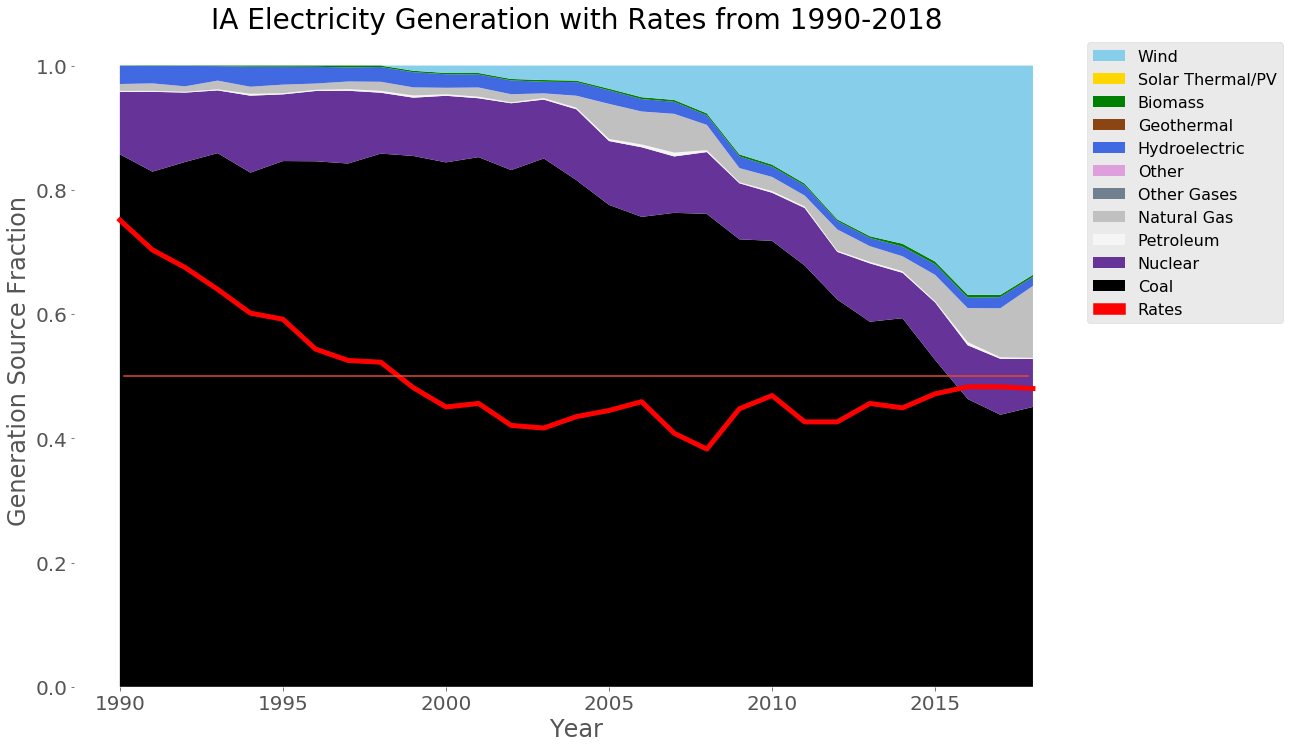

In [39]:
stack_rate(dfg, "IA", "gen_cols", 18, 12)

**Interpretation:** The thin red line represents the average, inflation-adjusted retail electricity rate for the state over the 1990-2018 time period. The thicker red line represents electricity rates for that year relative to the average. For Iowa, a state with a fairly straightforward trade of coal for wind generation, starting around 1995, the relationship between increasing renewable generation and retail rates is not clear. 

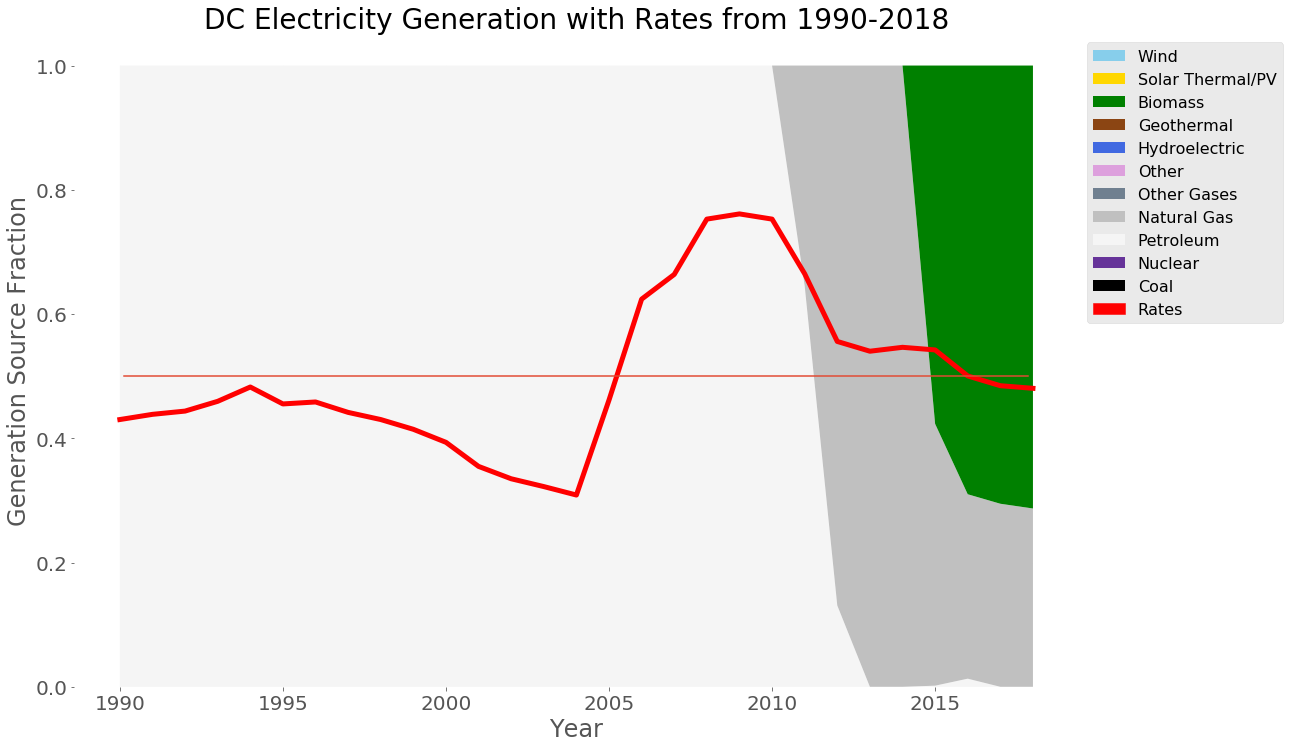

In [40]:
stack_rate(dfg, "DC", "gen_cols", 18, 12)

**Interpretation:** Washington, DC replaced petroleum generation with biomass and natural gas startig in 2010. The spike in electricity rates is likely due to the concomitant spike in oil prices which happened in the late 2000's. Here is a clear case where retail electricity rates declined as the renewable transition took hold. 

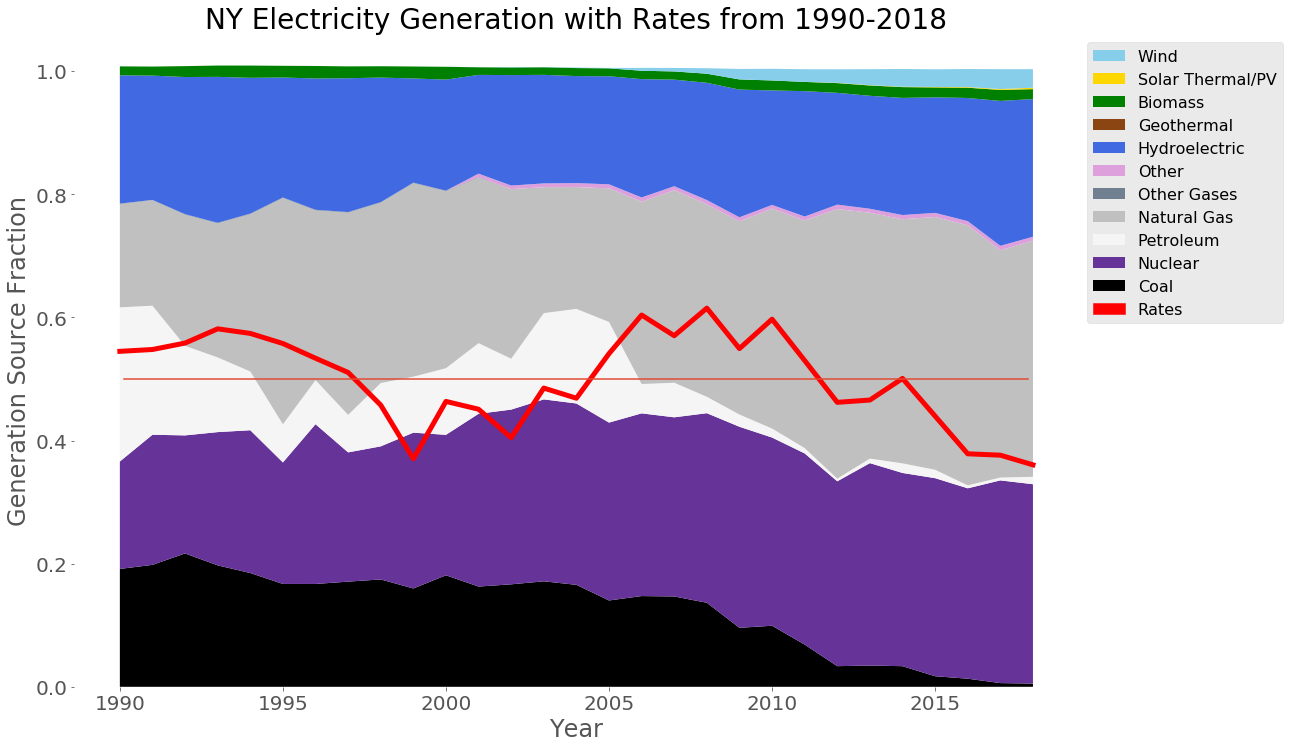

In [41]:
stack_rate(dfg, "NY", "gen_cols", 18, 12)

**Interpretation:** New York state's electricity rates could be said to fall as petroleum and coal generation decline and natural gas, nuclear, and wind increase. It is unlikely the relatively small wind component has the impact that other generation sources do. If wind were inherently expensive to integrate into the grid, we would see an outsize impact in Iowa's rates, which we do not.